# Setup

In [1]:
# List contents of the working directory
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/cifar-10/trainLabels.csv
/kaggle/input/cifar-10/sampleSubmission.csv
/kaggle/input/cifar-10/test.7z
/kaggle/input/cifar-10/train.7z


In [2]:
# Python package to open .7z archives
!pip install py7zr;

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.3/66.3 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 384.2/384.2 kB 10.4 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 45.5 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 357.2/357.2 kB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.6/93.6 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.6/138.6 kB 10.4 MB/s eta 0:00:00


In [3]:
# Import libraries

# Loading and processing
import glob
import cv2
import py7zr

# Data manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [4]:
!nvidia-smi

Fri Mar 24 19:35:31 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla T4            Off  | 00000000:00:05.0 Off |                    0 |
| N/A   

In [5]:
# Look for GPU
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# Loading the data

In [6]:
# Class labels
CLASS_NAMES = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

In [7]:
# Open training archive file

if not len(glob.glob('/kaggle/working/train/*.png')):
    with py7zr.SevenZipFile('/kaggle/input/cifar-10/train.7z', mode='r') as z:
        z.extractall()

In [8]:
# Convert the filepath to an integer image ID
def filename_to_id(filename):
    return int(filename.split('/')[-1].split('.')[0])

# Load all of the images into an array, also return the image IDs
def load_imgs_and_ids(img_directory_path):
    image_filenames = glob.glob(img_directory_path + '/*.png')
    list_of_images = []
    image_ids = []
    for f in image_filenames:
        image_id = filename_to_id(f) # E.G. '/kaggle/working/train/44240.png' -> 44240
        image_ids.append(image_id)
        data_array = cv2.imread(f)
        list_of_images.append(data_array)

    X = np.array(list_of_images)
    
    return X, image_ids
    
X_train, train_img_ids = load_imgs_and_ids('/kaggle/working/train')

# Read the labels from the CSV files and convert the array of IDs into a 0-9 code
train_labels_df = pd.read_csv('/kaggle/input/cifar-10/trainLabels.csv')
img_codes = [CLASS_NAMES.index(train_labels_df.loc[img_id-1]['label']) for img_id in train_img_ids]
y_train = np.array(img_codes)

X_train.shape, y_train.shape

((50000, 32, 32, 3), (50000,))

In [9]:
# Alternatively, could use data from Tensorflow
"""
from tensorflow.keras.datasets import cifar10

(X_train,y_train),(some_more_images,some_more_labels) = cifar10.load_data()
print(X_train.shape, y_train.shape)

y_train = y_train.reshape((50000,))
"""

'\nfrom tensorflow.keras.datasets import cifar10\n\n(X_train,y_train),(some_more_images,some_more_labels) = cifar10.load_data()\nprint(X_train.shape, y_train.shape)\n\ny_train = y_train.reshape((50000,))\n'

In [10]:
# RGB pixel values lie on a [0,...,255] scale. We rescale the channels to have channel intensities lie 
# from 0 to 1 inclusive

X_train = X_train / 255.0

# Visualization

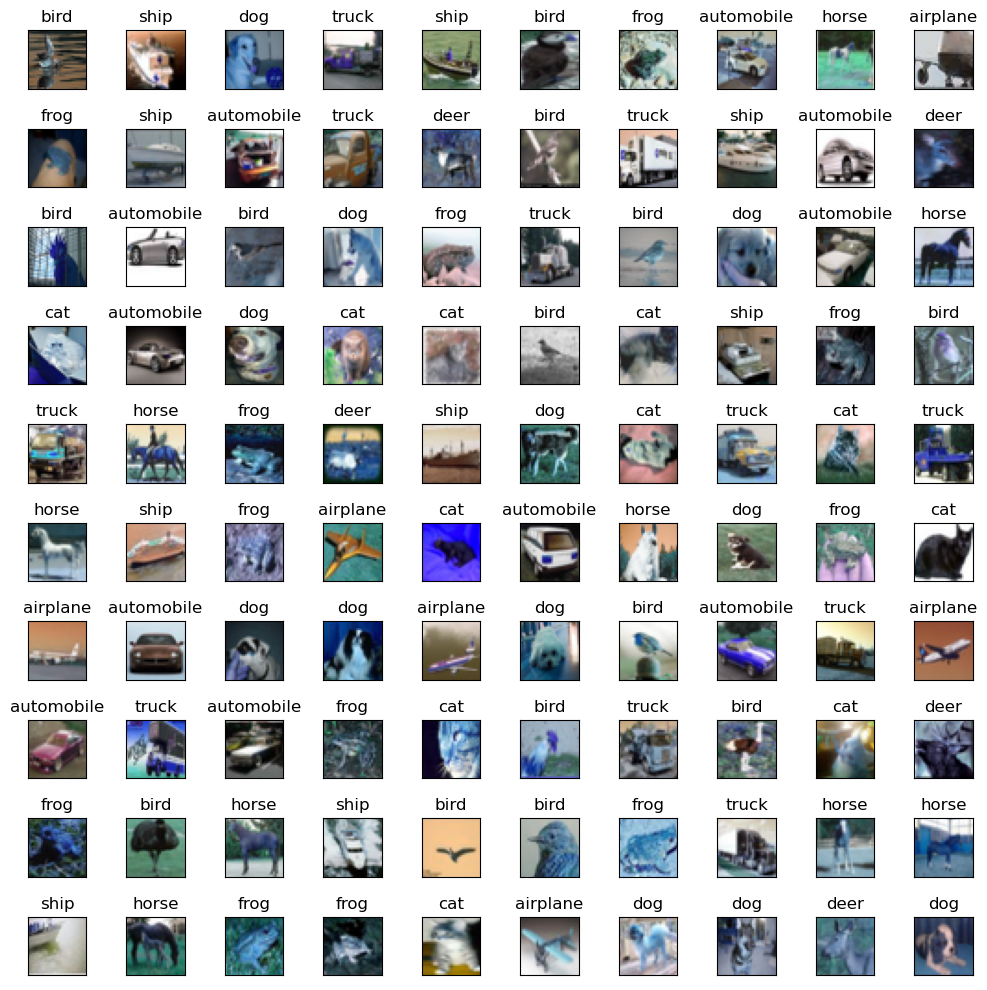

In [11]:
# To get a sense of the data we work with

plt.rcParams["figure.figsize"] = (10,10)
fig,axes = plt.subplots(10,10)
for i,ax in enumerate(axes.flatten()):
  ax.imshow(X_train[i])
  ax.set_title(f'{CLASS_NAMES[y_train[i]]}')
  ax.set_xticks([])
  ax.set_yticks([])
fig.tight_layout()

# Convolutional Neural Network Architecture

In [12]:
# CNN model, with 6 convolutional layers, 3 pooling layers, and 3 dense layers. Softmax output layer.
model = models.Sequential()

model.add(layers.Conv2D(64, (5,5), padding='same', activation='relu', input_shape=(32,32,3)))
model.add(layers.Conv2D(128, (3,3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2,2),strides=(2,2)))

model.add(layers.Conv2D(128, (3,3), padding='same', activation='relu'))
model.add(layers.Conv2D(128, (3,3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2,2)))

model.add(layers.Conv2D(128, (3,3), padding='same', activation='relu'))
model.add(layers.Conv2D(128, (3,3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2,2)))

model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        4864      
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 128)      0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 128)       147584    
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 128)       147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 128)        0         
 2D)                                                    

In [13]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

# Augmenting the training data and training the model

In [14]:
# We augment the training data within the mini-batches to try to reduce generalization error
datagen = ImageDataGenerator(
    horizontal_flip=True,
    channel_shift_range=0.05,
    rotation_range=10,
    validation_split=0.15
)

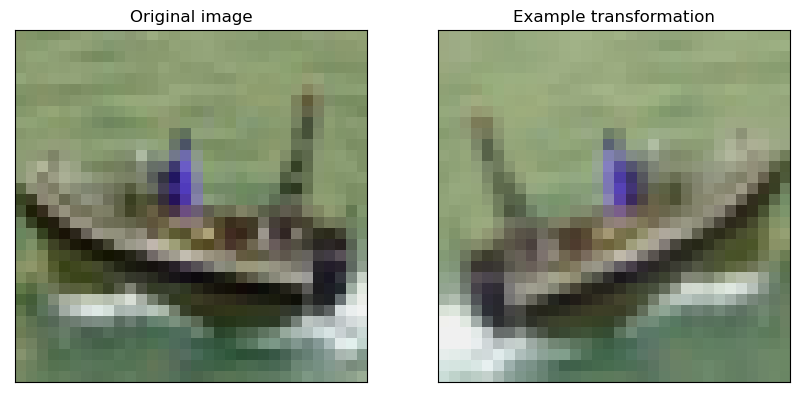

In [15]:
# An example transformation

img = X_train[4]

fig, ax = plt.subplots(1,2)
ax[0].imshow(img)
ax[0].set_title("Original image")
ax[1].imshow(datagen.apply_transform(img,{'theta':-10,'channel_shift_intensity':0.05,'flip_horizontal':True}))
ax[1].set_title("Example transformation")

for i in range(2):
  ax[i].set_xticks([])
  ax[i].set_yticks([])
plt.show()

In [16]:
# Train the model, including an early stopping if we can't reduce the loss further

early_stopping = keras.callbacks.EarlyStopping(monitor='loss',patience=10)

training_flow = datagen.flow(X_train, y_train, subset='training')
validation_flow = datagen.flow(X_train, y_train, subset='validation', shuffle=False)

history = model.fit(training_flow,
                    validation_data=validation_flow,
                    callbacks=[early_stopping],
                    epochs=75)

Epoch 1/75
1329/1329 [==============================] - 60s 34ms/step - loss: 1.7376 - accuracy: 0.3504 - val_loss: 1.5136 - val_accuracy: 0.4441
Epoch 2/75
1329/1329 [==============================] - 49s 37ms/step - loss: 1.3268 - accuracy: 0.5193 - val_loss: 1.1987 - val_accuracy: 0.5737
Epoch 3/75
1329/1329 [==============================] - 45s 34ms/step - loss: 1.1330 - accuracy: 0.5959 - val_loss: 1.1175 - val_accuracy: 0.6091
Epoch 4/75
1329/1329 [==============================] - 45s 34ms/step - loss: 0.9997 - accuracy: 0.6467 - val_loss: 1.0037 - val_accuracy: 0.6497
Epoch 5/75
1329/1329 [==============================] - 45s 34ms/step - loss: 0.8977 - accuracy: 0.6826 - val_loss: 0.9403 - val_accuracy: 0.6696
Epoch 6/75
1329/1329 [==============================] - 46s 35ms/step - loss: 0.8339 - accuracy: 0.7068 - val_loss: 0.9432 - val_accuracy: 0.6713
Epoch 7/75
1329/1329 [==============================] - 46s 35ms/step - loss: 0.7744 - accuracy: 0.7279 - val_loss: 0.8590 -

# Model evaluation

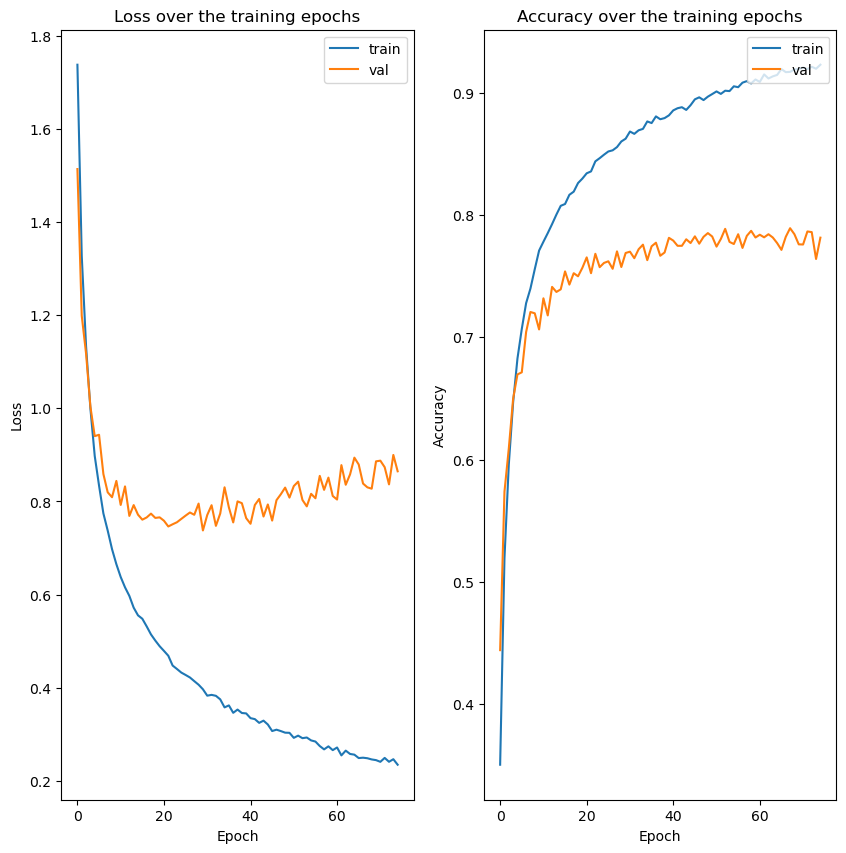

In [17]:
# Plot the evolution of training/validation error and accuracy

train_metrics = history.history

fig, ax = plt.subplots(1,2)
ax[0].plot(train_metrics['loss'])
ax[0].plot(train_metrics['val_loss'])
ax[0].legend(['train','val'], loc='upper right')
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].set_title("Loss over the training epochs")

ax[1].plot(train_metrics['accuracy'])
ax[1].plot(train_metrics['val_accuracy'])
ax[1].legend(['train','val'], loc='upper right')
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")
ax[1].set_title("Accuracy over the training epochs")

plt.show()

1/1 [==============================] - 0s 366ms/step


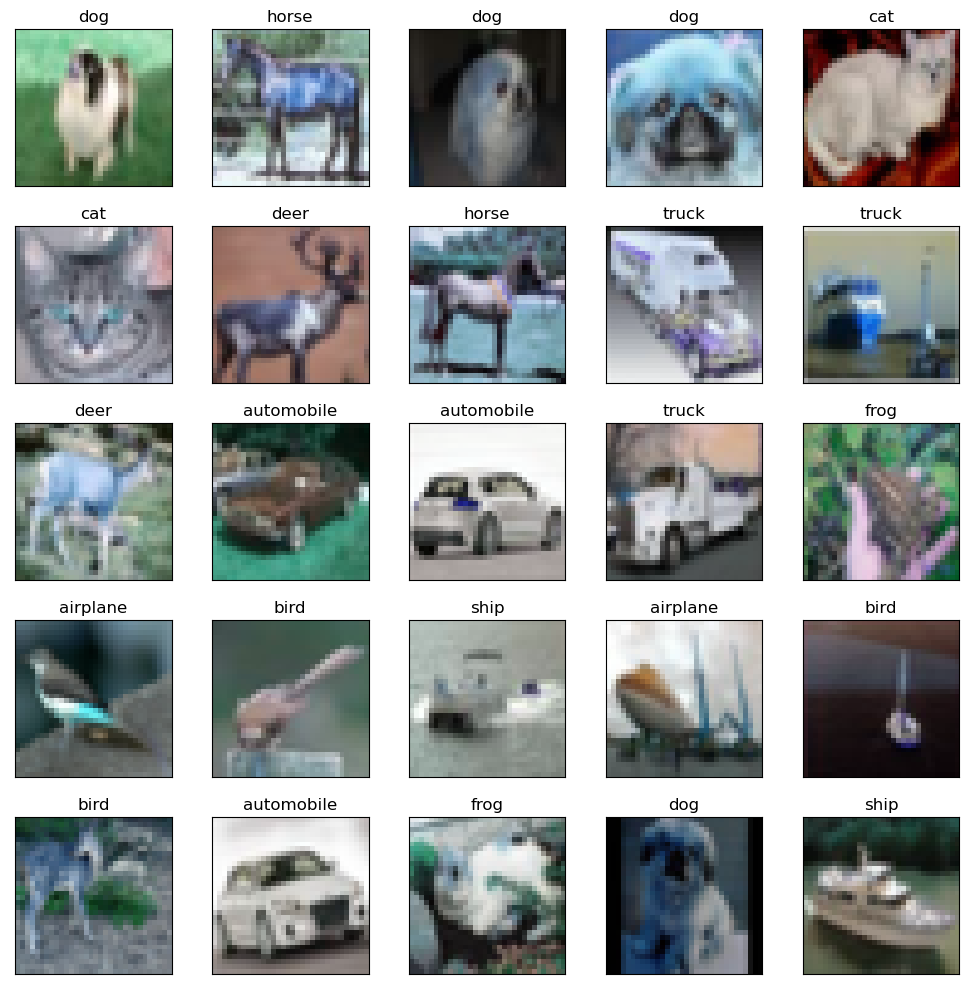

In [18]:
# Example predictions

sample_set = X_train[100:125]

sample_predictions = np.argmax(model.predict(sample_set),axis=1)

fig,axes = plt.subplots(5,5)
for i,ax in enumerate(axes.flatten()):
  ax.imshow(sample_set[i])
  ax.set_title(f'{CLASS_NAMES[sample_predictions[i]]}')
  ax.set_xticks([])
  ax.set_yticks([])
fig.tight_layout()

# Predictions on the test set

In [19]:
# Test set
if not len(glob.glob('/kaggle/working/test/*.png')):
    with py7zr.SevenZipFile('/kaggle/input/cifar-10/test.7z', mode='r') as z:
        z.extractall()

In [20]:
# Feed in the files from the directory. We do not attempt to load all images to memory at once
test_datagen = ImageDataGenerator(rescale=1/255.0)

test_flow = test_datagen.flow_from_directory('/kaggle/working/test',
                                            classes=['.'],
                                            target_size=(32,32),
                                            shuffle=False)

Found 300000 images belonging to 1 classes.


In [21]:
# Code -> classnames, and the helper function we made earlier
code_to_classname = {i:CLASS_NAMES[i] for i in range(len(CLASS_NAMES))}
def filename_to_id(filename):
    return int(filename.split('/')[-1].split('.')[0])

In [22]:
# Form predictions
test_flow.reset()

test_output = model.predict(test_flow)
test_prediction_codes = pd.Series(np.argmax(test_output, axis=1))
test_prediction_labels = test_prediction_codes.map(code_to_classname)

test_filenames = pd.Series(test_flow.filenames)
test_ids = test_filenames.apply(filename_to_id)

9375/9375 [==============================] - 132s 14ms/step


In [23]:
# Final cleaning up and output
out_df = pd.DataFrame({'id':test_ids,'label':test_prediction_labels})
out_df.sort_values(by=['id'], inplace=True)
out_df = out_df.reset_index(drop=True)
out_df = out_df.dropna()
out_df['id'] = out_df['id'].astype(int)

out_df.to_csv('/kaggle/working/submission.csv', index=False)